In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, PoissonRegressor, LinearRegression

import sys
sys.path.append('/home/rachel/Documents/lfp2spikes/modularized_code') 
from models.fit_model import MODEL_FITTING

In [3]:
fitter = MODEL_FITTING("sklearn")

In [4]:
buffer_size = 15
splits = [1]
bin_size = 20
c = (30, 2)
spike_type = "MUA"
spike_combo = "sumExt"
origin = 'zscored'

channels = "channels_1-5"

lfp_path = f'../data_prep/data/{spike_type}/{channels}/pat66_lfps{spike_type}_df_{origin}_c{c}_b{bin_size}'
spike_path = f'../data_prep/data/{spike_type}/{channels}/pat66_spikes{spike_type}_df_b{bin_size}_c{c}'

cv_df = fitter.load_split_data(
    splits, 
    lfp_path, 
    spike_path
)

In [6]:
X_df = cv_df[0][0]
y_df = cv_df[0][1]

X_train = X_df.train_dt[2]
#X_train = sm.add_constant(X_train)
y_train = y_df.train_dt[2]

In [7]:
print(X_train.shape)
print(y_train.shape)
reg_mod = PoissonRegressor(
    alpha=0.3, 
    tol=1E-8,
    max_iter=10000
            )
reg_mod.fit(X_train, y_train)

(1228344, 30)
(1228344,)


PoissonRegressor(alpha=0.3, max_iter=10000, tol=1e-08)

In [14]:
np.append(reg_mod.intercept_, reg_mod.coef_)

array([-5.20247997e+00,  5.05450398e-04,  6.42790084e-04,  7.83784528e-04,
        9.21135448e-04,  1.05131395e-03,  1.18636459e-03,  1.32508263e-03,
        1.45964286e-03,  1.61846759e-03,  1.80668713e-03,  2.01398488e-03,
        2.24189268e-03,  2.49158729e-03,  2.74638543e-03,  3.01308493e-03,
        3.26942099e-03,  3.52426306e-03,  3.75861171e-03,  3.97704577e-03,
        4.17245192e-03,  4.34259128e-03,  4.49896921e-03,  4.62641878e-03,
        4.73766273e-03,  4.83872777e-03,  4.91533167e-03,  4.96437215e-03,
        4.96482915e-03,  4.92150105e-03,  4.84158280e-03])

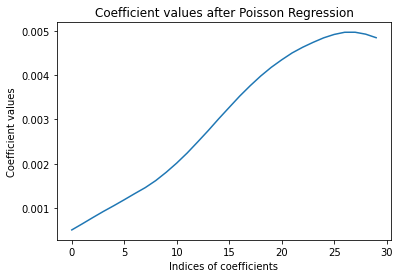

In [251]:
plt.title("Coefficient values after Poisson Regression")
#plt.title("STA over training data")
plt.xlabel("Indices of coefficients")
plt.ylabel("Coefficient values")
plt.plot(reg_mod.coef_.transpose())
#plt.plot(X_train[np.where(y_train>0)[0]].transpose().mean(axis=1))
plt.show()

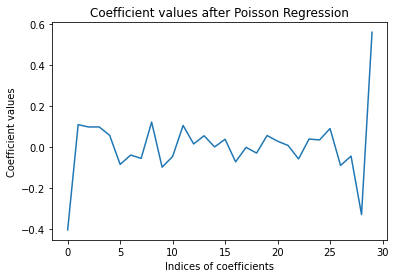

In [211]:
plt.title("Coefficient values after Poisson Regression")
#plt.title("STA over training data")
plt.xlabel("Indices of coefficients")
plt.ylabel("Coefficient values")
plt.plot(reg_mod.coef_.transpose())
#plt.plot(X_train[np.where(y_train>0)[0]].transpose().mean(axis=1))
plt.show()

In [170]:
from sklearn.metrics import log_loss
from sklearn.metrics import mean_poisson_deviance, d2_tweedie_score, r2_score

X_val = X_df.val_dt[0]
#X_train = sm.add_constant(X_train)
y_val = y_df.val_dt[0]

y_val_pred = reg_mod.predict(X_val)

print(mean_poisson_deviance(y_val, y_val_pred))
print(d2_tweedie_score(y_val, y_val_pred, power = 1))
print(r2_score(y_val, y_val_pred))

0.3627342883731255
0.00855756585818157
0.003593393551173274


In [310]:
model_params = {"alpha": 0.0, "L1_wt": 0.0, "cnvrg_tol": 1E-5}

In [311]:
model_no_indicators = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Poisson(),
)
#result_no_indicators = model_no_indicators.fit()
result_reg = model_no_indicators.fit_regularized(**model_params)
#print(result_no_indicators.summary())

In [196]:
print(result_no_indicators.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:              1228344
Model:                            GLM   Df Residuals:                  1228314
Model Family:                 Poisson   Df Model:                           29
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2305e+06
Date:                Tue, 19 Jul 2022   Deviance:                   2.3163e+06
Time:                        17:28:45   Pearson chi2:                 1.16e+06
No. Iterations:                     5   Pseudo R-squ. (CS):             -3.653
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0395      0.021     -1.865      0.0

In [258]:
model_no_indicators.loglike(result_reg.params)

-1230519.421176403

In [308]:
X_val = X_df.val_dt[0]
#X_train = sm.add_constant(X_train)
y_val = y_df.val_dt[0]

y_val_pred = model_no_indicators.predict(params=result_reg.params, exog=X_val)

rate = np.exp(X_val @ result_reg.params)

model_no_indicators.family.loglike(y_val, rate)

-236342.19054442586

In [309]:
# Compute the Poisson log likelihood
rate = np.exp(X_val @ result_reg.params)
log_lik = -(y_val @ np.log(rate) - rate.sum()) 
log_lik

235716.00242120886

In [304]:
result_reg.params.shape[-1]

30

In [296]:
def predict_self(
    X, 
    theta
):

    # Predict        
    y_pred = np.exp(X @ theta)

    return y_pred

In [284]:
model_no_indicators.predict(params=result_reg.params, exog=X_val)

array([1.00696458, 1.00777183, 1.00654867, ..., 1.00035166, 1.00185874,
       1.00447158])

In [297]:
predict_self(X_val, result_reg.params)

array([1.00696458, 1.00777183, 1.00654867, ..., 1.00035166, 1.00185874,
       1.00447158])

<AxesSubplot:>

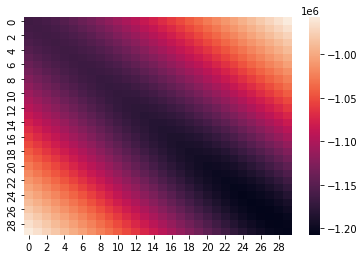

In [175]:
import seaborn as sns
fishInf = model_no_indicators.information(result_reg.params)
sns.heatmap(fishInf)

In [113]:
import statsmodels
from statsmodels.tools.tools import pinv_extended

pinv_wexog,_ = pinv_extended(X_train)
normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

final = statsmodels.genmod.generalized_linear_model.GLMResults(model_no_indicators, 
                                  result_reg.params, 
                                  normalized_cov_params, 
                                                              1)
print(final.summary())

AttributeError: 'GLMResults' object has no attribute 'method'

In [68]:
r = np.zeros_like(result_no_indicators.params)
r[5:7] = [1,-1]
result_no_indicators.t_test(r)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0007      0.058     -0.013      0.990      -0.115       0.113

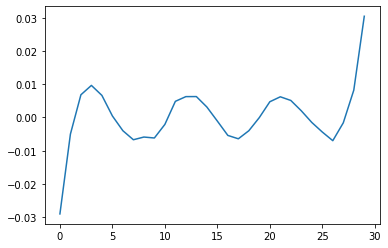

In [206]:
plt.plot(result_reg.params)
plt.show()

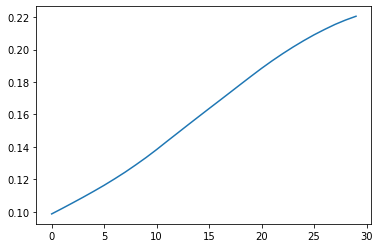

In [50]:
plt.plot(X_train[np.where(y_train>0)[0]].transpose().mean(axis=1))
plt.show()